/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


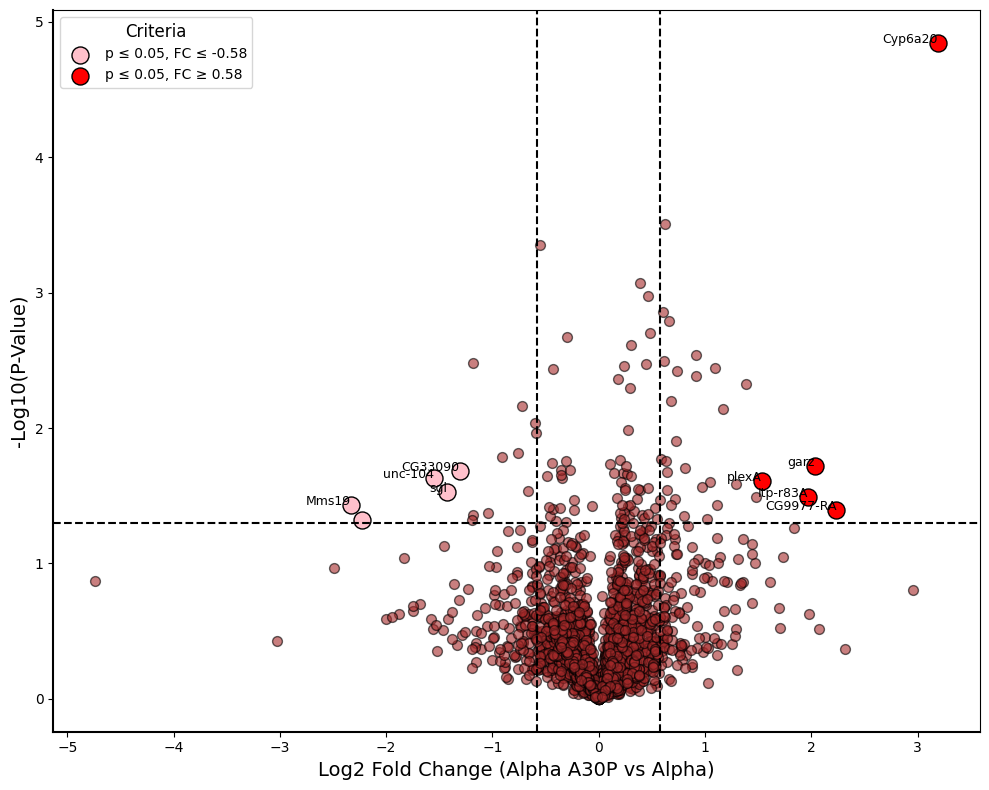

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Olagrace837/Final-Project/refs/heads/main/Alpha%20and%20Alpha%20A30P.csv'
df = pd.read_csv(url)

# --- Start of proposed change ---
# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()

# Dynamically identify control and KO columns based on common patterns.
# Assuming 'Alpha ' (without 'A30P') columns are controls, and 'Alpha A30P_' columns are knockouts.
# Using regex to capture columns matching the pattern 'Alpha _day_X_Y' or 'Alpha A30P_day_X_Y'
control_cols = sorted([col for col in df.columns if re.match(r'^Alpha _day_\d+_\d+$', col)])
ko_cols = sorted([col for col in df.columns if re.match(r'^Alpha A30P_day_\d+_\d+$', col)])

# If initial regex matching fails, try a more lenient approach, or print df.columns to inspect
if not control_cols:
    print("Attempting broader search for control columns...")
    control_cols = sorted([col for col in df.columns if 'Alpha ' in col and 'A30P' not in col and 'day' in col])
if not ko_cols:
    print("Attempting broader search for KO columns...")
    ko_cols = sorted([col for col in df.columns if 'Alpha A30P_' in col and 'day' in col])


if not control_cols:
    print(f"Error: No control columns found matching expected patterns. Identified columns: {df.columns.tolist()}")
    raise ValueError("Control columns not identified. Please check DataFrame column names and patterns.")
if not ko_cols:
    print(f"Error: No KO columns found matching expected patterns. Identified columns: {df.columns.tolist()}")
    raise ValueError("KO columns not identified. Please check DataFrame column names and patterns.")

numeric_cols = control_cols + ko_cols

for col in numeric_cols:
    # Replace '#VALUE!' string with NaN before converting to numeric
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[control_cols].mean(axis=1)
df['hnox_Mean'] = df[ko_cols].mean(axis=1)

# --- End of proposed change ---

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
# Ensure all values are numeric for t-test
t_stats, p_values = ttest_ind(
    df[control_cols].values,
    df[ko_cols].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# --- MODIFIED: Filter top 5 significant genes from both sides more explicitly ---
# Define significance and fold change thresholds for determining "top" genes
p_value_threshold = 0.05 # For statistical significance
log2_fc_threshold_abs = 0.58 # For biological significance (absolute value)

# Filter for genes that are statistically significant
significant_df = df[df['P_Value'] < p_value_threshold]

# Get the top 5 upregulated genes among significant ones (with positive Log2_FC above threshold)
top_5_up = significant_df[significant_df['Log2_FC'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC')

# Get the top 5 downregulated genes among significant ones (with negative Log2_FC below threshold)
top_5_down = significant_df[significant_df['Log2_FC'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC')

# Combine these to form the top_genes for labeling on the plot
top_genes = pd.concat([top_5_up, top_5_down]).drop_duplicates(subset=['Gene Name'] if 'Gene Name' in significant_df.columns else ['Gene names'])
# --- END MODIFIED SECTION ---

# Separate significant genes for coloring (these now filter from the new 'top_genes')
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown') # Changed color to brown

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='pink', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58') # Changed color to pink
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='red', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58') # Changed color to red

# Add gene labels
gene_name_col = 'Gene Name' if 'Gene Name' in df.columns else 'Gene names'
if gene_name_col not in df.columns:
    print("Warning: Neither 'Gene Name' nor 'Gene names' column found for labeling.")
else:
    top_genes_for_labeling = top_genes.dropna(subset=[gene_name_col])
    for _, row in top_genes_for_labeling.iterrows():
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row[gene_name_col], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (Alpha A30P vs Alpha)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
print("\nTop 5 Upregulated Genes:")
display(top_genes[top_genes['Log2_FC'] > 0].nlargest(5, 'Log2_FC')[['Gene Name', 'Log2_FC']])

print("\nTop 5 Downregulated Genes:")
display(top_genes[top_genes['Log2_FC'] < 0].nsmallest(5, 'Log2_FC')[['Gene Name', 'Log2_FC']])


Top 5 Upregulated Genes:


,Gene Name,Log2_FC
2364,CCNA_03966,4.586581
2364,CCNA_03966,4.586581
2152,CCNA_03997,2.178302
2152,CCNA_03997,2.178302
1177,CCNA_03271,2.001270



Top 5 Downregulated Genes:


,Gene Name,Log2_FC
1621,rsaA,-8.411241
1621,rsaA,-8.411241
39,CCNA_00858,-1.256778
39,CCNA_00858,-1.256778


In [7]:
day1_control_cols = sorted([col for col in control_cols if 'day_1' in col])
day1_ko_cols = sorted([col for col in ko_cols if 'day_1' in col])

print(f"Day 1 Control Columns: {day1_control_cols}")
print(f"Day 1 KO Columns: {day1_ko_cols}")

Day 1 Control Columns: ['Alpha _day_10_1', 'Alpha _day_10_2', 'Alpha _day_1_1', 'Alpha _day_1_2']
Day 1 KO Columns: ['Alpha A30P_day_10_1', 'Alpha A30P_day_10_2', 'Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']


In [8]:
day1_control_cols = sorted([col for col in control_cols if '_day_1_' in col and '_day_10_' not in col and '_day_1_1' in col or '_day_1_2' in col])
day1_ko_cols = sorted([col for col in ko_cols if '_day_1_' in col and '_day_10_' not in col and '_day_1_1' in col or '_day_1_2' in col])

# Ensure enough replicates for t-test (at least 2 in each group) - optional but good practice
if len(day1_control_cols) < 2 or len(day1_ko_cols) < 2:
    raise ValueError("Not enough replicates for Day 1 t-test. Please check column names.")

print(f"Corrected Day 1 Control Columns: {day1_control_cols}")
print(f"Corrected Day 1 KO Columns: {day1_ko_cols}")

# 2. Calculate mean expression for Day 1 control replicates
df['WT_Mean_day1'] = df[day1_control_cols].mean(axis=1)

# 3. Calculate mean expression for Day 1 knockout replicates
df['hnox_Mean_day1'] = df[day1_ko_cols].mean(axis=1)

# 4. Compute the Log2 Fold Change for Day 1
df['Log2_FC_day1'] = (df['hnox_Mean_day1'] - df['WT_Mean_day1'].replace(0, np.nan))

# 5. Perform a two-sample independent t-test for Day 1
t_stats_day1, p_values_day1 = ttest_ind(
    df[day1_control_cols].values,
    df[day1_ko_cols].values,
    axis=1, nan_policy='omit'
)
df['P_Value_day1'] = p_values_day1

# 6. Calculate the negative base-10 logarithm of the P_Value_day1
df['MinusLog10_P_day1'] = -np.log10(df['P_Value_day1'])

df_day1_analysis = df[['Gene names', 'WT_Mean_day1', 'hnox_Mean_day1', 'Log2_FC_day1', 'P_Value_day1', 'MinusLog10_P_day1']].head()
print("\nDataFrame with Day 1 analysis results:")
display(df_day1_analysis)


Corrected Day 1 Control Columns: ['Alpha _day_1_1', 'Alpha _day_1_2']
Corrected Day 1 KO Columns: ['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df



DataFrame with Day 1 analysis results:


,Gene names,WT_Mean_day1,hnox_Mean_day1,Log2_FC_day1,P_Value_day1,MinusLog10_P_day1
0,NaN,-1.144903,-0.839753,0.305150,0.554187,0.256344
1,dnc,-1.453550,-2.092368,-0.638818,0.187253,0.727571
2,NaN,NaN,-1.984845,NaN,NaN,NaN
3,Marf,-1.119664,-1.310763,-0.191099,0.609765,0.214838
4,Rh4,-0.369930,-0.655028,-0.285098,0.920061,0.036184


In [10]:
day1_control_cols = sorted([col for col in control_cols if '_day_1_' in col and 'day_10' not in col])
day1_ko_cols = sorted([col for col in ko_cols if '_day_1_' in col and 'day_10' not in col])

# Ensure enough replicates for t-test (at least 2 in each group) - optional but good practice
if len(day1_control_cols) < 2 or len(day1_ko_cols) < 2:
    raise ValueError("Not enough replicates for Day 1 t-test. Please check column names.")

print(f"Corrected Day 1 Control Columns: {day1_control_cols}")
print(f"Corrected Day 1 KO Columns: {day1_ko_cols}")

# 2. Calculate mean expression for Day 1 control replicates
df['WT_Mean_day1'] = df[day1_control_cols].mean(axis=1)

# 3. Calculate mean expression for Day 1 knockout replicates
df['hnox_Mean_day1'] = df[day1_ko_cols].mean(axis=1)

# 4. Compute the Log2 Fold Change for Day 1
df['Log2_FC_day1'] = (df['hnox_Mean_day1'] - df['WT_Mean_day1'].replace(0, np.nan))

# 5. Perform a two-sample independent t-test for Day 1
t_stats_day1, p_values_day1 = ttest_ind(
    df[day1_control_cols].values,
    df[day1_ko_cols].values,
    axis=1, nan_policy='omit'
)
df['P_Value_day1'] = p_values_day1

# 6. Calculate the negative base-10 logarithm of the P_Value_day1
df['MinusLog10_P_day1'] = -np.log10(df['P_Value_day1'])

df_day1_analysis = df[['Gene names', 'WT_Mean_day1', 'hnox_Mean_day1', 'Log2_FC_day1', 'P_Value_day1', 'MinusLog10_P_day1']].head()
print("\nDataFrame with Day 1 analysis results:")
display(df_day1_analysis)


Corrected Day 1 Control Columns: ['Alpha _day_1_1', 'Alpha _day_1_2']
Corrected Day 1 KO Columns: ['Alpha A30P_day_1_1', 'Alpha A30P_day_1_2']

DataFrame with Day 1 analysis results:


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


,Gene names,WT_Mean_day1,hnox_Mean_day1,Log2_FC_day1,P_Value_day1,MinusLog10_P_day1
0,NaN,-1.144903,-0.839753,0.305150,0.554187,0.256344
1,dnc,-1.453550,-2.092368,-0.638818,0.187253,0.727571
2,NaN,NaN,-1.984845,NaN,NaN,NaN
3,Marf,-1.119664,-1.310763,-0.191099,0.609765,0.214838
4,Rh4,-0.369930,-0.655028,-0.285098,0.920061,0.036184


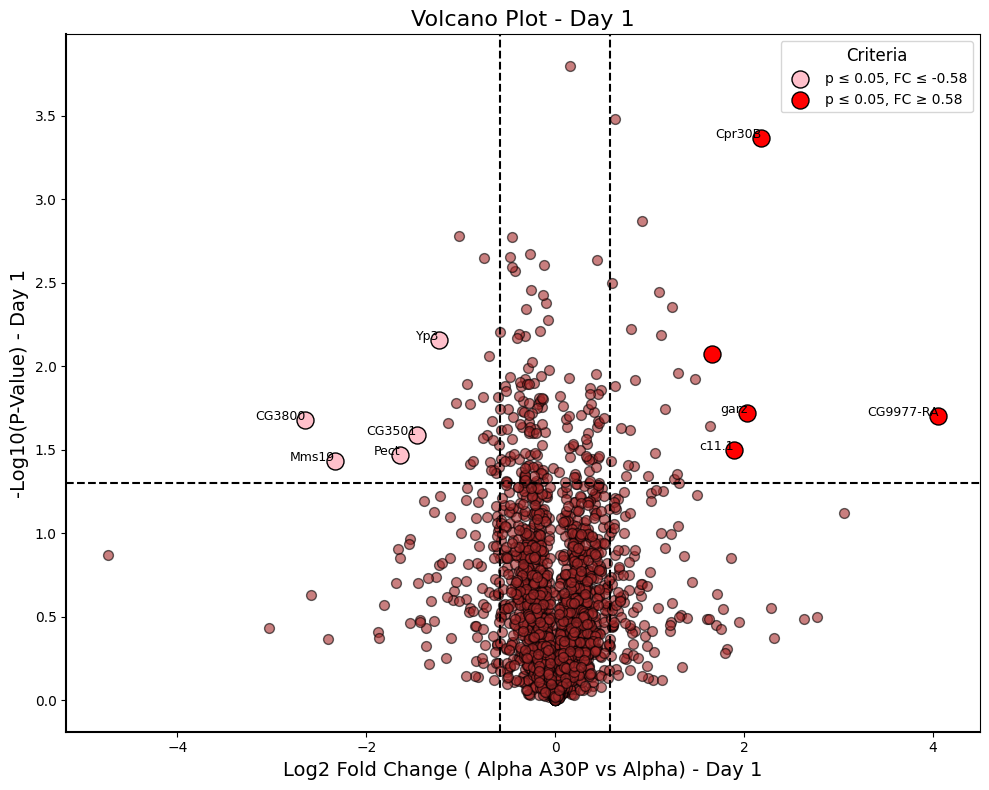

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define significance and fold change thresholds for Day 1
p_value_threshold_day1 = 0.05
log2_fc_threshold_abs_day1 = 0.58

# Filter for genes that are statistically significant for Day 1
significant_df_day1 = df[df['P_Value_day1'] < p_value_threshold_day1].copy()

# Get the top 5 upregulated genes among significant ones (with positive Log2_FC_day1 above threshold)
top_5_up_day1 = significant_df_day1[significant_df_day1['Log2_FC_day1'] >= log2_fc_threshold_abs_day1].nlargest(5, 'Log2_FC_day1')

# Get the top 5 downregulated genes among significant ones (with negative Log2_FC_day1 below threshold)
top_5_down_day1 = significant_df_day1[significant_df_day1['Log2_FC_day1'] <= -log2_fc_threshold_abs_day1].nsmallest(5, 'Log2_FC_day1')

# Combine these to form the top_genes_day1 for labeling on the plot
top_genes_day1 = pd.concat([top_5_up_day1, top_5_down_day1]).drop_duplicates(subset=['Gene names'])

# Separate significant genes for coloring
left_candidates_day1 = top_genes_day1[top_genes_day1['Log2_FC_day1'] < -log2_fc_threshold_abs_day1]
right_candidates_day1 = top_genes_day1[top_genes_day1['Log2_FC_day1'] >= log2_fc_threshold_abs_day1]

# Create the volcano plot for Day 1
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC_day1'], df['MinusLog10_P_day1'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

# Highlight significant genes for Day 1
plt.scatter(left_candidates_day1['Log2_FC_day1'], left_candidates_day1['MinusLog10_P_day1'], color='pink', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day1}, FC ≤ -{log2_fc_threshold_abs_day1}')
plt.scatter(right_candidates_day1['Log2_FC_day1'], right_candidates_day1['MinusLog10_P_day1'], color='red', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day1}, FC ≥ {log2_fc_threshold_abs_day1}')

# Add gene labels for Day 1
gene_name_col = 'Gene names' # Assuming 'Gene names' is the correct column based on previous steps
if gene_name_col not in df.columns:
    print("Warning: 'Gene names' column not found for labeling. Please check DataFrame columns.")
else:
    top_genes_for_labeling_day1 = top_genes_day1.dropna(subset=[gene_name_col])
    for _, row in top_genes_for_labeling_day1.iterrows():
        plt.text(row['Log2_FC_day1'], row['MinusLog10_P_day1'], row[gene_name_col], fontsize=9, ha='right')

# Add reference lines for Day 1
plt.axhline(-np.log10(p_value_threshold_day1), color='black', linestyle='--')
plt.axvline(log2_fc_threshold_abs_day1, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs_day1, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend for Day 1
plt.xlabel('Log2 Fold Change ( Alpha A30P vs Alpha) - Day 1', fontsize=14)
plt.ylabel('-Log10(P-Value) - Day 1', fontsize=14)
plt.title('Volcano Plot - Day 1', fontsize=16)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
day10_control_cols = sorted([col for col in control_cols if '_day_10_' in col])
day10_ko_cols = sorted([col for col in ko_cols if '_day_10_' in col])

# Ensure enough replicates for t-test (at least 2 in each group) - optional but good practice
if len(day10_control_cols) < 2 or len(day10_ko_cols) < 2:
    raise ValueError("Not enough replicates for Day 10 t-test. Please check column names.")

print(f"Day 10 Control Columns: {day10_control_cols}")
print(f"Day 10 KO Columns: {day10_ko_cols}")

# 3. Calculate mean expression for Day 10 control replicates
df['WT_Mean_day10'] = df[day10_control_cols].mean(axis=1)

# 4. Calculate mean expression for Day 10 knockout replicates
df['hnox_Mean_day10'] = df[day10_ko_cols].mean(axis=1)

# 5. Compute the Log2 Fold Change for Day 10
df['Log2_FC_day10'] = (df['hnox_Mean_day10'] - df['WT_Mean_day10'].replace(0, np.nan))

# 6. Perform a two-sample independent t-test for Day 10
t_stats_day10, p_values_day10 = ttest_ind(
    df[day10_control_cols].values,
    df[day10_ko_cols].values,
    axis=1, nan_policy='omit'
)
df['P_Value_day10'] = p_values_day10

# 7. Calculate the negative base-10 logarithm of the P_Value_day10
df['MinusLog10_P_day10'] = -np.log10(df['P_Value_day10'])

# 8. Display the head of the DataFrame with Day 10 analysis results
df_day10_analysis = df[['Gene names', 'WT_Mean_day10', 'hnox_Mean_day10', 'Log2_FC_day10', 'P_Value_day10', 'MinusLog10_P_day10']].head()
print("\nDataFrame with Day 10 analysis results:")
display(df_day10_analysis)


Day 10 Control Columns: ['Alpha _day_10_1', 'Alpha _day_10_2']
Day 10 KO Columns: ['Alpha A30P_day_10_1', 'Alpha A30P_day_10_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df



DataFrame with Day 10 analysis results:


,Gene names,WT_Mean_day10,hnox_Mean_day10,Log2_FC_day10,P_Value_day10,MinusLog10_P_day10
0,NaN,NaN,-1.406534,NaN,NaN,NaN
1,dnc,-1.749455,-1.972470,-0.223015,0.632060,0.199242
2,NaN,-1.155623,-1.737259,-0.581636,0.562528,0.249856
3,Marf,-1.838056,-1.884446,-0.046390,0.908706,0.041577
4,Rh4,NaN,-1.680287,NaN,NaN,NaN


In [13]:
day10_control_cols = sorted([col for col in control_cols if '_day_10_' in col])
day10_ko_cols = sorted([col for col in ko_cols if '_day_10_' in col])

# Ensure enough replicates for t-test (at least 2 in each group) - optional but good practice
if len(day10_control_cols) < 2 or len(day10_ko_cols) < 2:
    raise ValueError("Not enough replicates for Day 10 t-test. Please check column names.")

print(f"Day 10 Control Columns: {day10_control_cols}")
print(f"Day 10 KO Columns: {day10_ko_cols}")

# 3. Calculate mean expression for Day 10 control replicates
df['WT_Mean_day10'] = df[day10_control_cols].mean(axis=1)

# 4. Calculate mean expression for Day 10 knockout replicates
df['hnox_Mean_day10'] = df[day10_ko_cols].mean(axis=1)

# 5. Compute the Log2 Fold Change for Day 10
df['Log2_FC_day10'] = (df['hnox_Mean_day10'] - df['WT_Mean_day10'].replace(0, np.nan))

# 6. Perform a two-sample independent t-test for Day 10
t_stats_day10, p_values_day10 = ttest_ind(
    df[day10_control_cols].values,
    df[day10_ko_cols].values,
    axis=1, nan_policy='omit'
)
df['P_Value_day10'] = p_values_day10

# Replace NaN p-values with 1.0 (no significance) to avoid issues with -log10 and plotting.
# This addresses the SmallSampleWarning by treating genes with insufficient data as non-significant.
df['P_Value_day10'] = df['P_Value_day10'].fillna(1.0)

# 7. Calculate the negative base-10 logarithm of the P_Value_day10
# Now, -log10(1.0) will be 0, placing these genes at the bottom of the plot as non-significant.
df['MinusLog10_P_day10'] = -np.log10(df['P_Value_day10'])

# 8. Display the head of the DataFrame with Day 10 analysis results
df_day10_analysis = df[['Gene names', 'WT_Mean_day10', 'hnox_Mean_day10', 'Log2_FC_day10', 'P_Value_day10', 'MinusLog10_P_day10']].head()
print("\nDataFrame with Day 10 analysis results:")
display(df_day10_analysis)


Day 10 Control Columns: ['Alpha _day_10_1', 'Alpha _day_10_2']
Day 10 KO Columns: ['Alpha A30P_day_10_1', 'Alpha A30P_day_10_2']


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df



DataFrame with Day 10 analysis results:


,Gene names,WT_Mean_day10,hnox_Mean_day10,Log2_FC_day10,P_Value_day10,MinusLog10_P_day10
0,NaN,NaN,-1.406534,NaN,1.000000,-0.000000
1,dnc,-1.749455,-1.972470,-0.223015,0.632060,0.199242
2,NaN,-1.155623,-1.737259,-0.581636,0.562528,0.249856
3,Marf,-1.838056,-1.884446,-0.046390,0.908706,0.041577
4,Rh4,NaN,-1.680287,NaN,1.000000,-0.000000


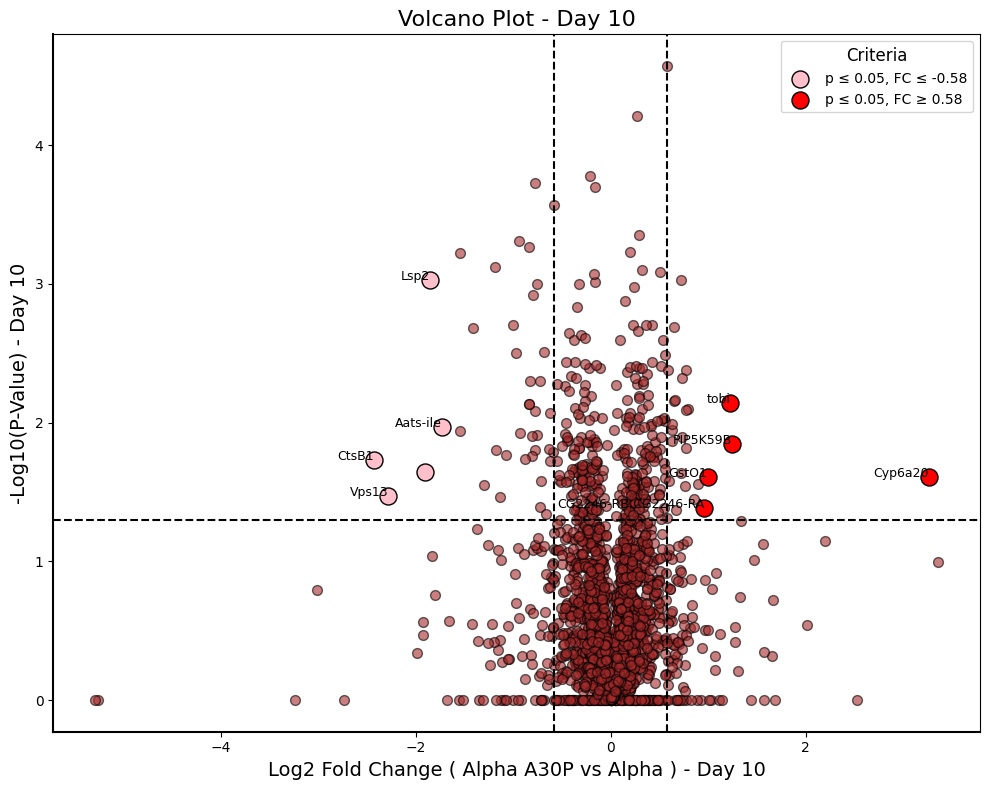

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define significance and fold change thresholds for Day 10
p_value_threshold_day10 = 0.05
log2_fc_threshold_abs_day10 = 0.58

# Filter for genes that are statistically significant for Day 10
significant_df_day10 = df[df['P_Value_day10'] < p_value_threshold_day10].copy()

# Get the top 5 upregulated genes among significant ones (with positive Log2_FC_day10 above threshold)
top_5_up_day10 = significant_df_day10[significant_df_day10['Log2_FC_day10'] >= log2_fc_threshold_abs_day10].nlargest(5, 'Log2_FC_day10')

# Get the top 5 downregulated genes among significant ones (with negative Log2_FC_day10 below threshold)
top_5_down_day10 = significant_df_day10[significant_df_day10['Log2_FC_day10'] <= -log2_fc_threshold_abs_day10].nsmallest(5, 'Log2_FC_day10')

# Combine these to form the top_genes_day10 for labeling on the plot
top_genes_day10 = pd.concat([top_5_up_day10, top_5_down_day10]).drop_duplicates(subset=['Gene names'])

# Separate significant genes for coloring
left_candidates_day10 = top_genes_day10[top_genes_day10['Log2_FC_day10'] < -log2_fc_threshold_abs_day10]
right_candidates_day10 = top_genes_day10[top_genes_day10['Log2_FC_day10'] >= log2_fc_threshold_abs_day10]

# Create the volcano plot for Day 10
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC_day10'], df['MinusLog10_P_day10'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

# Highlight significant genes for Day 10
plt.scatter(left_candidates_day10['Log2_FC_day10'], left_candidates_day10['MinusLog10_P_day10'], color='pink', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day10}, FC ≤ -{log2_fc_threshold_abs_day10}')
plt.scatter(right_candidates_day10['Log2_FC_day10'], right_candidates_day10['MinusLog10_P_day10'], color='red', s=150, edgecolor='black', marker='o', label=f'p ≤ {p_value_threshold_day10}, FC ≥ {log2_fc_threshold_abs_day10}')

# Add gene labels for Day 10
gene_name_col = 'Gene names' # Assuming 'Gene names' is the correct column based on previous steps
if gene_name_col not in df.columns:
    print("Warning: 'Gene names' column not found for labeling. Please check DataFrame columns.")
else:
    top_genes_for_labeling_day10 = top_genes_day10.dropna(subset=[gene_name_col])
    for _, row in top_genes_for_labeling_day10.iterrows():
        plt.text(row['Log2_FC_day10'], row['MinusLog10_P_day10'], row[gene_name_col], fontsize=9, ha='right')

# Add reference lines for Day 10
plt.axhline(-np.log10(p_value_threshold_day10), color='black', linestyle='--')
plt.axvline(log2_fc_threshold_abs_day10, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs_day10, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend for Day 10
plt.xlabel('Log2 Fold Change ( Alpha A30P vs Alpha ) - Day 10', fontsize=14)
plt.ylabel('-Log10(P-Value) - Day 10', fontsize=14)
plt.title('Volcano Plot - Day 10', fontsize=16)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()